<a href="https://colab.research.google.com/github/apof/ChAI---GPs---Master-Thesis/blob/main/Neural_Net_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/SNLP/')
import utils

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
inputs = joblib.load('drive/MyDrive/Datasets/ChAIVectors/aluminium_vectors')
labels = joblib.load('drive/MyDrive/Datasets/ChAIVectors/aluminium_labels')
dates = joblib.load('drive/MyDrive/Datasets/ChAIVectors/dates')

In [ ]:
print(inputs.shape)
print(labels.shape)
print(dates.shape)

(973, 3, 30)
(973,)
(973,)


In [ ]:
train_batches,validation_batches,test_batches = utils.train_test_split(inputs,labels,dates,inputs.shape[0],0.9,0)

In [ ]:
train_data,train_labels,train_dates = train_batches[0]
test_data,test_labels,test_dates = test_batches[0]
val_data,val_labels,val_dates = validation_batches[0]
print("Train Dates: " + train_dates[0] + " " + train_dates[-1])
print("Val Dates: " + val_dates[0] + " " + val_dates[-1])
print("Test Dates: " + test_dates[0] + " " + test_dates[-1])

Train Dates: 2017-05-19 2020-09-25
Val Dates: 2020-09-28 2020-12-03
Test Dates: 2020-12-03 2021-02-09


In [ ]:
train_data = torch.from_numpy(train_data).to(dtype=torch.float16).to(device)
train_labels = torch.from_numpy(train_labels).to(device)
test_data = torch.from_numpy(test_data).to(dtype=torch.float16).to(device)
test_labels = torch.from_numpy(test_labels).to(device)
val_data = torch.from_numpy(val_data).to(dtype=torch.float16).to(device)
val_labels = torch.from_numpy(val_labels).to(device)

In [ ]:
train_labels = torch.reshape(train_labels, (train_labels.shape[0], 1))
test_labels = torch.reshape(test_labels, (test_labels.shape[0], 1))
val_labels = torch.reshape(val_labels, (val_labels.shape[0], 1))

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)

torch.Size([876, 3, 30])
torch.Size([876, 1])
torch.Size([49, 3, 30])
torch.Size([49, 1])
torch.Size([49, 3, 30])
torch.Size([49, 1])


In [ ]:
## define a dictionary with the parameters of the Neural Network
params_dictionary = {}
params_dictionary['embedding_size'] = train_data[0].shape[1]
params_dictionary['hidden_dim'] = 64
params_dictionary['linear_dims'] = [16,8]
params_dictionary['bidirectional'] = False
params_dictionary['label_size'] = 1
params_dictionary['dropout'] = 0.0
params_dictionary['rnn_layers_num'] = 1
params_dictionary['attention_layer'] = False

In [ ]:
class Attention(nn.Module):
    def __init__(self, device,hidden_size):
        super(Attention, self).__init__()
        self.device = device
        self.hidden_size = hidden_size

        self.concat_linear = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, hidden_size)

        ## add this model the same same device with the RNN
        self.to(device)

    def forward(self, rnn_outputs, final_hidden_state):
        attn_weights = self.attn(rnn_outputs) # (batch_size, seq_len, hidden_dim)
        attn_weights = torch.bmm(attn_weights, final_hidden_state.unsqueeze(2))
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        context = torch.bmm(rnn_outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
        attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, final_hidden_state), dim=1)))
        return attn_hidden, attn_weights

In [ ]:
class RnnRegressor(nn.Module):
    def __init__(self, device, params_dictionary):
        super(RnnRegressor, self).__init__()
        self.params = params_dictionary
        self.device = device

        # Calculate number of directions
        self.num_directions = 2 if self.params.get('bidirectional') == True else 1

        # define an attention model
        # Choose attention model
        self.attention = Attention(self.device,self.params.get('hidden_dim')* self.num_directions)

        ## here store in a list all the dimensions of the layers rnn_output --> linear layers --> labels layer
        self.linear_dims = [self.params.get('hidden_dim') * self.num_directions] + self.params.get('linear_dims')
        self.linear_dims.append(self.params.get('label_size'))

        # Work with LSTM cell for now
        self.rnn = nn.LSTM

        ## define the RNN layer
        self.rnn = self.rnn(self.params.get('embedding_size'),
                            self.params.get('hidden_dim'),
                            num_layers=self.params.get('rnn_layers_num'),
                            bidirectional=self.params.get('bidirectional'),
                            dropout=float(self.params.get('dropout')),
                            batch_first=True)
        
        ## the hidden state of the RNN empty for now
        self.hidden = None
        
        # Define set of fully connected layers (Linear Layer + Activation Layer)
        ## this set of layers takes the output of the RNN or the Attention layer and applies a feedforward NN on it
        ## consecutive linear + Relu layers are applied (the final layer does not have a relu activation!)
        self.linears = nn.ModuleList()
        for i in range(0, len(self.linear_dims)-1):
            if self.params.get('dropout') > 0.0:
                self.linears.append(nn.Dropout(p=self.params.get('dropout')))
            linear_layer = nn.Linear(self.linear_dims[i], self.linear_dims[i+1])
            self.init_weights(linear_layer)
            self.linears.append(linear_layer)
            if i == len(self.linear_dims) - 1:
                break
            self.linears.append(nn.ReLU())

        self.to(self.device)

    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

    def init_hidden(self, batch_size):
        return (torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device),
              torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device))
      

    def forward(self, inputs):
        batch_size, seq_len, embedding_size = inputs.shape


        embedded_inputs = inputs

        ## initialise the hidden state of the RNN
        self.hidden = self.init_hidden(batch_size)

        ## pass the data through the recurrent layer
        rnn_output, self.hidden = self.rnn(embedded_inputs.float(), self.hidden)

        ## Collect last hidden state
        final_state = self.hidden[0].view(self.params.get('rnn_layers_num'), self.num_directions, batch_size, self.params.get('hidden_dim'))[-1]

        # Handle directions if more than one
        final_hidden_state = None
        ## in case we have only one direction
        if self.num_directions == 1:
            final_hidden_state = final_state.squeeze(0)
        ## in case we have 2 directions concatenate these two states
        elif self.num_directions == 2:
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1)  # Concatenate both states

        ## Attention Layer
        if(self.params.get('attention_layer') == False):
            X = final_hidden_state
        else:
            rnn_output = rnn_output.permute(1, 0, 2)
            X, attention_weights = self.attention(rnn_output, final_hidden_state)

        # Push through linear layers
        for l in self.linears:
            X = l(X)

        return X

In [ ]:
model = RnnRegressor(device,params_dictionary)

In [ ]:
loss = nn.MSELoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
train_loss = []
valid_loss = []

training_iter = 1000
    
#for early stopping :
best_cost=1000000 
stop = False
last_improvement=0
require_improvement = 15
best_model = None
epoch = 0

while epoch < training_iter and stop == False:

    epoch += 1
    loss_batches = []
    optimizer.zero_grad()
    y_pred = model.forward(train_data)
    single_loss = loss(y_pred,train_labels.float()).to(device)
    single_loss.backward()
    optimizer.step()
    train_loss.append(single_loss.item())

    ## compute and store the validation loss
    valid_pred = model.forward(val_data)
    val_loss = loss(valid_pred,val_labels.float().to(device)).item()
    valid_loss.append(val_loss)

    print("epoch  " + str(epoch) + " " + str(train_loss[-1]))
    print("epoch  " + str(epoch) + " " + str(valid_loss[-1]))
    clear_output(wait=True)

    avg_cost = val_loss
    if avg_cost < best_cost:
      best_cost = avg_cost
      last_improvement = 0
      best_model = model
    else:
      last_improvement +=1
            
    if last_improvement > require_improvement:
      print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
      # Break out from the loop.
      stop = True
      model = best_model
            

No improvement found during the last iterations, stopping optimization at epoch: 59


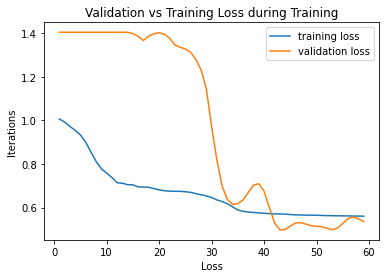

In [ ]:
iters = [i+1 for i in range(len(train_loss))]
plt.plot(iters, train_loss ,label = "training loss")
plt.plot(iters, valid_loss, label = "validation loss")
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Validation vs Training Loss during Training')
plt.legend()
plt.show()

In [ ]:
validation_predictions = model.forward(val_data).detach().numpy()
test_predictions = model.forward(test_data).detach().numpy()
test_labels = test_labels.detach().numpy()
val_labels = val_labels.detach().numpy()

In [ ]:
index_1 = [i+1 for i in range(len(validation_predictions))]
index_2 = [i+1 for i in range(len(test_predictions))]

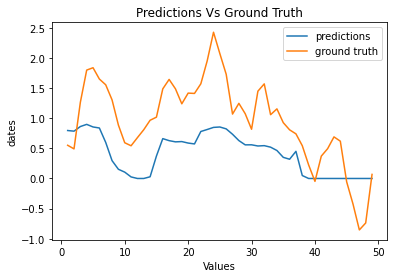

In [ ]:
plt.plot(index_1, validation_predictions ,label = "predictions")
plt.plot(index_1, val_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

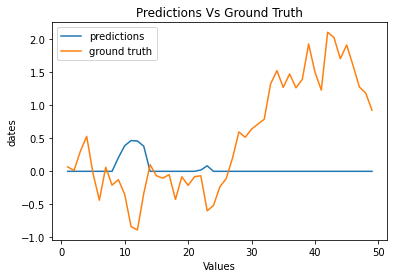

In [ ]:
plt.plot(index_2, test_predictions ,label = "predictions")
plt.plot(index_2, test_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

In [ ]:
print(test_labels.shape)
print(test_predictions.shape)

(49, 1)
(49, 1)


In [ ]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(test_labels,test_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(test_predictions, test_labels)))

Mean Directional Accuracy: 0.5625
Root Mean Squared Error : 0.9994401618240579


In [ ]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(val_labels,validation_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(validation_predictions, val_labels)))

Mean Directional Accuracy: 0.5625
Root Mean Squared Error : 0.731702502211773
